# üåü Introduction

Dataset used in this notebook aims to classificate stars, galaxies, and quasars based on their spectral characteristics. Support Vector Machine (SVM) and Random Forest algorithms are used for classification purposes in this notebook. The dataset is an imbalanced dataset. For this reason, Synthetic Minority Oversampling Technique (SMOTE) is used to eliminate the imbalance between classes. Outlier values are detected with the Local Outlier Factor and these values are removed from the dataset. In the 16-dimensional data set, the correlations of the features with the class label are checked and the features with a correlation greater than 0.16 are used for classification. In addition, the seaborn library and the yellow brick library are used for data visualization.

<img src="https://media2.giphy.com/media/OYfQ5c7FPeBxe/giphy.gif">

### üí´ Content

1. [Cargar y revisar los datos](#1)
1. [Detectar Outliers o Datos atipicos](#2)
1. [Seleccion de Caracteristicas](#3)
1. [Desbalance de Datos](#4)


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

<a id='1'></a><br>
# Cargar y revisar los datos

In [2]:
df = pd.read_csv("data/star_classification.csv")

df.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [3]:
# informacion basica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Lo que deseamos predecir eventualmente es la clase, 
- Galaxia
- Estrella
- Quasar

In [4]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

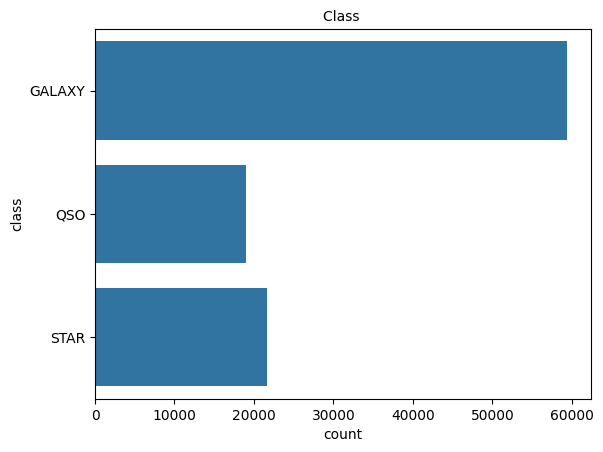

In [5]:
sns.countplot(df["class"])
plt.title("Class ",fontsize=10)
plt.show()

Le entregaremos un numero a cada valor, se puede hacer con if's o un map, el map es una operacion mas elegante y facil de leer, asi que es recomendada

In [6]:
df["class"] = df["class"].map({"GALAXY": 0, "STAR": 1, "QSO": 2})
df["class"].value_counts()

class
0    59445
1    21594
2    18961
Name: count, dtype: int64

<a id='2'></a><br>
# Detectar Outliers
Son aquellos datos que se comportan de manera muy variable, suelen ser una *cantidad muy baja* comparada con el total de datos y sugieren que deben trabajarse con un modelo distinto

Incluirlos puede provocar que nuestro modelo intente generalizarlos cuando los rige un fenomeno distinto, esto provoca que el modelo se envene y empeore su prediccion para los datos que no son `outliers`

`LocalOutlierFactor` es un algoritmo no supervisado, que crea una vecindad de datos y aquellos muy lejanos al comportamiento tipico, son considerados datos atipicos

In [7]:
# Existe mateamtica para predecir outliers, hoy en la era moderna es posible correr unas 3 lineas de codigo
# nota: esta celda puede tomar tiempo en correr

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df) 

In [8]:
# le asigna un puntjae, cuanto mas negativo, mas probabilidad  de ser un outlier
x_score = clf.negative_outlier_factor_
# creamos un dataframe para contener todos los puntajes
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()


In [9]:
# el index indica cual es un outlier
len(outlier_index)

15256

In [10]:
df.drop(outlier_index, inplace=True) # quita el outlier del lugar

<a id='3'></a><br>
# Feature Selection o Eleccion de Caracteristicas

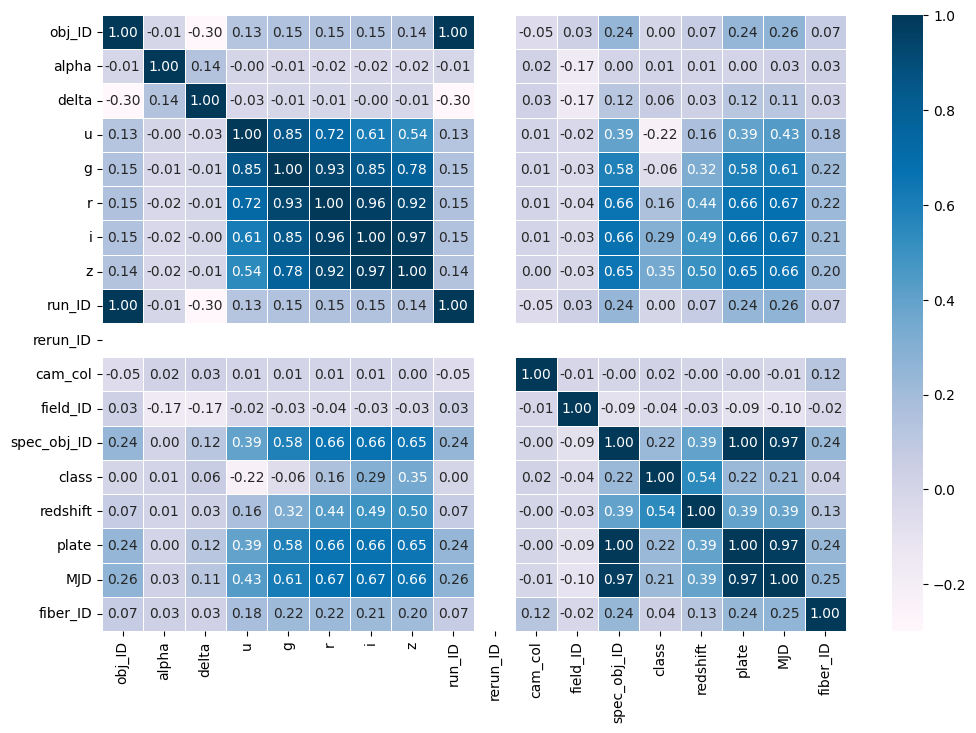

In [11]:
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

Lo que medimos es la correlacion, si un valor aumenta que ocurre con los otros?

Por ejemplo 
- si abro el grifo de agua por un largo tiempo, espero que aumente la cantidad de agua en el balde que deje abajo (una correlacion positiva).


In [12]:
corr = df.corr()
corr

obj_ID     alpha     delta         u         g         r  \
obj_ID       1.000000 -0.007595 -0.298596  0.131724  0.151542  0.154268   
alpha       -0.007595  1.000000  0.138266 -0.000401 -0.012023 -0.019830   
delta       -0.298596  0.138266  1.000000 -0.029000 -0.007362 -0.006433   
u            0.131724 -0.000401 -0.029000  1.000000  0.851703  0.724977   
g            0.151542 -0.012023 -0.007362  0.851703  1.000000  0.932447   
r            0.154268 -0.019830 -0.006433  0.724977  0.932447  1.000000   
i            0.147686 -0.020549 -0.003689  0.614238  0.846505  0.962658   
z            0.140506 -0.022386 -0.005127  0.541793  0.775100  0.918971   
run_ID       1.000000 -0.007597 -0.298597  0.131723  0.151541  0.154266   
rerun_ID          NaN       NaN       NaN       NaN       NaN       NaN   
cam_col     -0.048111  0.019790  0.029248  0.005663  0.005562  0.005945   
field_ID     0.032558 -0.169471 -0.168250 -0.023399 -0.032498 -0.035651   
spec_obj_ID  0.240267  0.004254  0.119294  0.393969  0.584472  0.657631   
class        0.000252  0.008187  0.058947 -0.222802 -0.058192  0.160654   
redshift     0.066438  0.005316  0.033121  0.164270  0.319042  0.435026   
plate        0.240267  0.004253  0.119294  0.393967  0.584471  0.657630   
MJD          0.263391  0.026993  0.113676  0.434743  0.611249  0.673350   
fiber_ID     0.067175  0.034421  0.028948  0.180359  0.218364  0.221695   

                    i         z    run_ID  rerun_ID   cam_col  field_ID  \
obj_ID       0.147686  0.140506  1.000000       NaN -0.048111  0.032558   
alpha       -0.020549 -0.022386 -0.007597       NaN  0.019790 -0.169471   
delta       -0.003689 -0.005127 -0.298597       NaN  0.029248 -0.168250   
u            0.614238  0.541793  0.131723       NaN  0.005663 -0.023399   
g            0.846505  0.775100  0.151541       NaN  0.005562 -0.032498   
r            0.962658  0.918971  0.154266       NaN  0.005945 -0.035651   
i            1.000000  0.971290  0.147685       NaN  0.005514 -0.034792   
z            0.971290  1.000000  0.140505       NaN  0.004947 -0.033912   
run_ID       0.147685  0.140505  1.000000       NaN -0.048212  0.032558   
rerun_ID          NaN       NaN       NaN       NaN       NaN       NaN   
cam_col      0.005514  0.004947 -0.048212       NaN  1.000000 -0.010892   
field_ID    -0.034792 -0.033912  0.032558       NaN -0.010892  1.000000   
spec_obj_ID  0.664511  0.647782  0.240266       NaN -0.002502 -0.089253   
class        0.294075  0.349711  0.000250       NaN  0.017789 -0.037542   
redshift     0.494385  0.503320  0.066438       NaN -0.001565 -0.025317   
plate        0.664510  0.647780  0.240266       NaN -0.002504 -0.089253   
MJD          0.674806  0.656364  0.263390       NaN -0.007281 -0.104053   
fiber_ID     0.213878  0.203660  0.067162       NaN  0.123522 -0.017391   

             spec_obj_ID     class  redshift     plate       MJD  fiber_ID  
obj_ID          0.240267  0.000252  0.066438  0.240267  0.263391  0.067175  
alpha           0.004254  0.008187  0.005316  0.004253  0.026993  0.034421  
delta           0.119294  0.058947  0.033121  0.119294  0.113676  0.028948  
u               0.393969 -0.222802  0.164270  0.393967  0.434743  0.180359  
g               0.584472 -0.058192  0.319042  0.584471  0.611249  0.218364  
r               0.657631  0.160654  0.435026  0.657630  0.673350  0.221695  
i               0.664511  0.294075  0.494385  0.664510  0.674806  0.213878  
z               0.647782  0.349711  0.503320  0.647780  0.656364  0.203660  
run_ID          0.240266  0.000250  0.066438  0.240266  0.263390  0.067162  
rerun_ID             NaN       NaN       NaN       NaN       NaN       NaN  
cam_col        -0.002502  0.017789 -0.001565 -0.002504 -0.007281  0.123522  
field_ID       -0.089253 -0.037542 -0.025317 -0.089253 -0.104053 -0.017391  
spec_obj_ID     1.000000  0.224718  0.392665  1.000000  0.970375  0.239102  
class           0.224718  1.000000  0.541667  0.224718  0.214433  0.037319  
redshift

Si seleccionamos una columna como

```python
corr["class"]
```

Estaremos observando cuales son las correlaciones con las clases que tenemos

In [13]:
corr["class"].sort_values()

u             -0.222802
g             -0.058192
field_ID      -0.037542
run_ID         0.000250
obj_ID         0.000252
alpha          0.008187
cam_col        0.017789
fiber_ID       0.037319
delta          0.058947
r              0.160654
MJD            0.214433
spec_obj_ID    0.224718
plate          0.224718
i              0.294075
z              0.349711
redshift       0.541667
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

La hipotesis de utilizar las correlaciones:
Correlaciones bajas en magnitud, cercanas a 0 tendran poca importancia para la prediccion de la clase `class`

Puede ser mucho m√°s util que tomemos el cuadrado de la correlacion, de manera que los valores muy cercanos a 0 se aproximen a√∫n m√°s.

- Nota: Observa como hay una correlacion de 1 con `class` pues la correlacion de algo consigo mismo es maxima y perfecta, por tanto no entrega informacion

In [14]:
correlacioncuadrada = corr["class"]**2
correlacioncuadrada

obj_ID         6.326622e-08
alpha          6.702476e-05
delta          3.474713e-03
u              4.964057e-02
g              3.386329e-03
r              2.580971e-02
i              8.648032e-02
z              1.222977e-01
run_ID         6.238597e-08
rerun_ID                NaN
cam_col        3.164481e-04
field_ID       1.409424e-03
spec_obj_ID    5.049811e-02
class          1.000000e+00
redshift       2.934034e-01
plate          5.049827e-02
MJD            4.598133e-02
fiber_ID       1.392735e-03
Name: class, dtype: float64

In [15]:
correlacioncuadrada.drop(["rerun_ID","class"], inplace=True) # botamos la Nan y la propia columna class

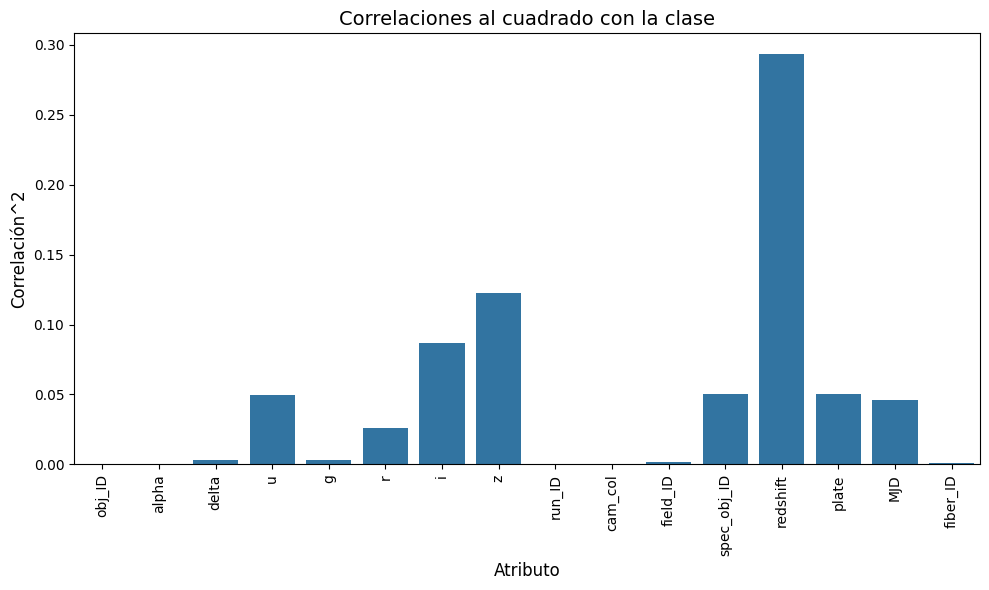

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x=correlacioncuadrada.index, y=correlacioncuadrada.values)

# A√±adir t√≠tulos y etiquetas
plt.title('Correlaciones al cuadrado con la clase', fontsize=14)
plt.xlabel('Atributo', fontsize=12)
plt.ylabel('Correlaci√≥n^2', fontsize=12)
plt.xticks(rotation=90)

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

Explicacion de correlaciones muy bajas
- `obj_ID` es un numero arbitrario y unico para cada objeto en el cielo, ya que no se toma en orden no tienen ninguna influencia con la clase estelar, es como suponer que el numero de telefono permite predcir la profesion de una persona.
- `fiber_ID` tambien es un identificador como el anterior

Las otras correlaciones a 0 podrian tener relaciones `no lineales`, en caso de que por una buena razon sospechemos que estas son muy importantes tendriamos que aplicar metodos de ML no lineales como `redes neuronales` o `arboles de decision`

In [17]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

## Guardar el dataset trabajado

### Prepararlo en train y testing
Si hacemos metodos como oversampling, al separar en `train` y `test` podemos tener datos repetidos, lo que hara que nuestro metodo para predecir no sea objetivo y se vea sesgado a darnos mejores resultados de lo que en verdad sea

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Divide el DataFrame en train y test (80% entrenamiento, 20% prueba)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)



In [22]:
df_train.head()

u         g         r         i         z   spec_obj_ID  class  \
13158  22.39001  22.34083  21.98772  21.76028  21.34358  8.847496e+18      2   
53959  23.74433  20.75764  19.02456  18.34559  18.11704  5.016017e+18      0   
54997  23.43193  22.05075  21.92739  21.90023  23.20461  1.032691e+19      1   
55717  22.75731  21.47175  21.22910  21.23370  20.79656  7.311744e+18      2   
30890  20.79732  20.78409  20.70544  20.58816  20.57125  9.223534e+18      2   

       redshift  plate    MJD  
13158  1.389701   7858  57281  
53959  0.345586   4455  55539  
54997 -0.000509   9172  58015  
55717  2.598834   6494  56363  
30890  0.905309   8192  57348

In [23]:
df_test.head()

u         g         r         i         z   spec_obj_ID  class  \
19146  22.45291  22.54372  21.92260  21.44131  21.32762  1.076163e+19      0   
11642  20.11504  18.35507  17.45793  17.02329  16.70585  1.764406e+18      0   
92293  18.64502  18.61753  18.31365  18.23245  18.21811  3.715536e+18      2   
790    20.87098  18.33453  17.75295  17.55940  17.52090  3.750344e+17      0   
54358  20.88227  21.05757  20.52429  20.61162  20.40757  9.253922e+18      2   

       redshift  plate    MJD  
19146  0.808124   9558  57806  
11642  0.054056   1567  53172  
92293  1.363222   3300  54914  
790    0.284462    333  52313  
54358  1.287501   8219  57429

<a id='4'></a><br>
# Desbalance de datos

Como observamos antes, tenemos muchos mas casos de Galaxias comparados a los otros 2, esto por lo general provoca que el modelo aproveche esta disparejidad y prediga la mayoria de veces `Galaxia` (0), los modelos son flojos y si encuentran algun truco o atajo, estos seran aprovechados, aun si eso provoca una mala generalizacion

In [19]:
# metodo de sklearn
from sklearn.utils import resample
import pandas as pd
from collections import Counter

In [20]:
# Dividir X e y
x = df_train.drop(['class'], axis=1)
y = df_train['class']

# Combinar los datos para que est√©n juntos en un DataFrame
data = pd.concat([x, y], axis=1)

# Mostrar el balance original de las clases
print('Dataset original cuentas: %s' % Counter(y))

# Separar las clases
class_0 = data[data['class'] == 0]  # Galaxias (por ejemplo)
class_1 = data[data['class'] == 1]  # Estrellas (por ejemplo)
class_2 = data[data['class'] == 2]  # Qu√°sares (por ejemplo)

# Determinar la clase mayoritaria
max_class_count = max(len(class_0), len(class_1), len(class_2))

# Hacer oversample de las clases minoritarias
class_0_upsampled = resample(class_0, replace=True, n_samples=max_class_count, random_state=42)
class_1_upsampled = resample(class_1, replace=True, n_samples=max_class_count, random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=max_class_count, random_state=42)

# Combinar las clases nuevamente
upsampled_data = pd.concat([class_0_upsampled, class_1_upsampled, class_2_upsampled])

# Separar X e y nuevamente despu√©s de hacer el oversampling
x_upsampled = upsampled_data.drop('class', axis=1)
y_upsampled = upsampled_data['class']

# Mostrar el nuevo balance de clases
print('Dataset modificado cuentas: %s' % Counter(y_upsampled))


Dataset original cuentas: Counter({0: 40474, 1: 14349, 2: 12972})
Dataset modificado cuentas: Counter({0: 40474, 1: 40474, 2: 40474})


Como se observa, repetimos muchas veces los datos con menos incidencia para que fueran tantos como la clase mayoritaria.

Ya que deseamos usar estos datos para entrenamiento vamos a almacenarlos como tal en el `csv`

In [24]:
# Guardar los datos en archivos CSV
upsampled_data.to_csv("data/train.csv", index=False)
df_test.to_csv('data/test.csv', index=False)